In [1]:
import torch
from torch_geometric.datasets import EllipticBitcoinDataset, EllipticBitcoinTemporalDataset

from ogb.nodeproppred import PygNodePropPredDataset

In [2]:
from pathlib import Path
from torch_geometric.data import Dataset
import networkx as nx
import numpy as np
import torch_geometric

def built_dblp():
    path = Path('../data/dblp-hard-citation-graph/dblp-hard/')
    y = np.load(path/"y.npy")
    x = np.load(path/"X.npy")
    node_year = np.load(path/"t.npy")
    nx_graph = nx.read_adjlist(path/"adjlist.txt", nodetype=int)
    data = torch_geometric.utils.from_networkx(nx_graph)
    data.x = torch.tensor(x)
    data.y = torch.unsqueeze(torch.tensor(y), 1)
    data.node_year = torch.unsqueeze(torch.tensor(node_year),1)
    num_classes = np.unique(y).shape[0]
    #ds = Dataset(data, num_classes)
    return data

In [3]:
elliptic = EllipticBitcoinDataset(root='./data/Elliptic/') # labels 0: licit, 1: illicit, 2: unlabeled
ogbn_arxiv = PygNodePropPredDataset(name="ogbn-arxiv", root = './data/Ogbn/')
dblp = built_dblp()

In [4]:
import networkx as nx
import numpy as np

def convert_labels_to_consecutive_integers(labels):
    unique_labels = np.unique(labels)
    labels_map = {label: i for i, label in enumerate(unique_labels)}
    new_labels = np.array([labels_map[label] for label in labels])

    return new_labels

def h_edge(graph, labels):
    """Compute edge homophily."""
    edges_with_same_label = 0
    for u, v in graph.edges:
        if labels[u] == labels[v]:
            edges_with_same_label += 1

    h_edge = edges_with_same_label / len(graph.edges)

    return h_edge

def h_adj(graph, labels):
    """Compute adjusted homophily."""
    #labels = convert_labels_to_consecutive_integers(labels)

    num_classes = len(np.unique(labels))

    degree_sums = np.zeros((num_classes,))
    for u in graph.nodes:
        label = labels[u]
        degree_sums[label] += graph.degree(u)

    adjust = (degree_sums ** 2 / (len(graph.edges) * 2) ** 2).sum()

    h_adj = (h_edge(graph, labels) - adjust) / (1 - adjust)

    return h_adj

In [5]:
def get_graph_and_labels_from_pyg_dataset(dataset):
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset.x)))
    graph.add_edges_from(dataset.edge_index.T.numpy())

    labels = dataset.y.numpy()

    return graph, labels

In [6]:
graph, labels = get_graph_and_labels_from_pyg_dataset(dblp)
print('dblp', f'{h_adj(graph, labels):.3f}')

graph, labels = get_graph_and_labels_from_pyg_dataset(ogbn_arxiv)
print('ogbn', f'{h_adj(graph, labels):.3f}')

graph, labels = get_graph_and_labels_from_pyg_dataset(elliptic)
print('elliptic', f'{h_adj(graph, labels):.3f}')

dblp 0.238
ogbn 0.588
elliptic 0.326


In [7]:
from collections import Counter
import pandas as pd

column_names = ['Year', 'Classes', 'Smallest class', 'Biggest class', 'Total nodes']
df = pd.DataFrame(columns=column_names)
class_counter = Counter()
years = []
classes = []
for year in torch.unique(ogbn_arxiv.node_year).numpy():
    years.append(year)
    counter = Counter(ogbn_arxiv.y[ogbn_arxiv.node_year == year].numpy())
    class_counter.update(counter)
    new_row = pd.Series({'Year': year, 'Classes': len(class_counter.keys()), 'Smallest class': min(class_counter.values()), 'Biggest class': max(class_counter.values()), 'Total nodes': sum(class_counter.values())})
    df = pd.concat([df, pd.DataFrame([new_row], columns=new_row.index)]).reset_index(drop=True)
    classes.append(len(class_counter.keys()))
#print(df.to_latex(index=False))
print(df.to_string(index=False))

Year Classes Smallest class Biggest class Total nodes
1971       1              1             1           1
1986       2              1             1           2
1987       3              1             1           3
1988       4              1             1           4
1990       6              1             2           7
1991       8              1             2          10
1992       8              1             2          11
1993       8              1             8          19
1994       8              1            23          38
1995       9              1            45          63
1996      12              1            63          94
1997      15              1            77         127
1998      19              1            99         250
1999      25              1           126         415
2000      31              1           183         676
2001      35              1           220         924
2002      36              1           294        1279
2003      37              1 

D:\Users\Productivity\anaconda3\envs\cudanew\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [8]:
years_dblp = []
classes_dblp = []
class_counter = Counter()
observed_classes = set()
for year in torch.unique(dblp.node_year).numpy():
    class_counter.update(Counter(dblp.y[dblp.node_year == year].numpy()))
    if year == 2004:
        observed_classes = set(class_counter.keys())
    years_dblp.append(year)
    classes_dblp.append(len(class_counter.keys()))

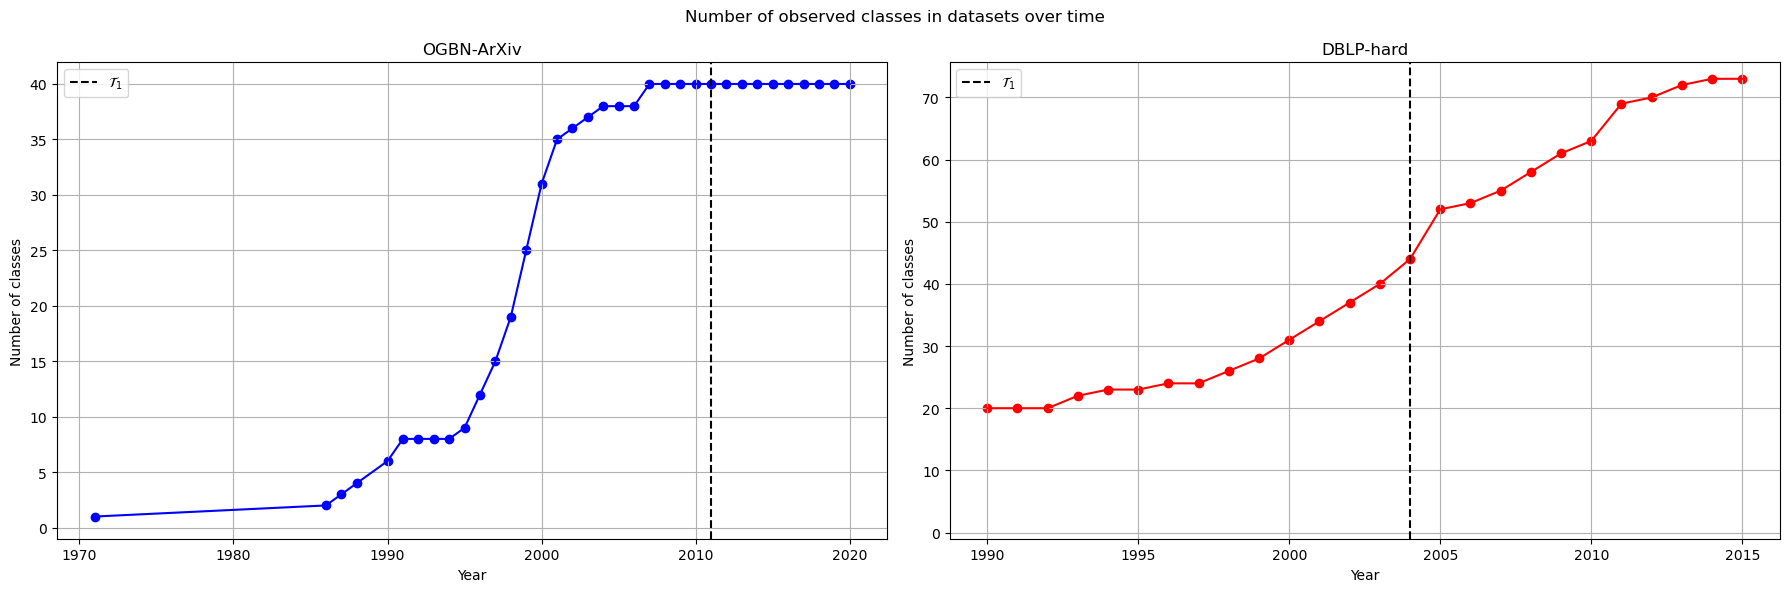

In [9]:
import matplotlib.pyplot as plt

interp_years = np.arange(years[0], years[-1] + 1)
interp_classes = np.interp(interp_years, years, classes)

years_dblp_interp = np.arange(min(years_dblp), max(years_dblp) + 1)
classes_dblp_interp = np.interp(years_dblp_interp, years_dblp, classes_dblp)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].scatter(years, classes, color='blue')
axs[0].plot(interp_years, interp_classes, color='blue', linestyle='-')
axs[0].axvline(x=2011, color='black', linestyle='--', label=r'$\mathcal{T}_{1}$')
#axs[0].text(2011, 1, r' $\mathcal{T}_{1}$', verticalalignment='bottom')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of classes')
axs[0].set_title('OGBN-ArXiv')
axs[0].grid(True)
axs[0].set_ylim(-1)
axs[0].legend()

# Plot for the second set of data
axs[1].scatter(years_dblp, classes_dblp, color='red')
axs[1].plot(years_dblp_interp, classes_dblp_interp, color='red', linestyle='-')
axs[1].axvline(x=2004, color='black', linestyle='--', label=r'$\mathcal{T}_{1}$')
#axs[1].text(2004, 2, r' $\mathcal{T}_{1}$', verticalalignment='bottom')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of classes')
axs[1].set_title('DBLP-hard')
axs[1].grid(True)
axs[1].set_ylim(-1)
axs[1].legend()

plt.suptitle('Number of observed classes in datasets over time')
plt.tight_layout()
plt.savefig('observed_classes.pdf')
plt.show()

## Distribution shifts for real-world data

### Feature shift of OGBN-ArXiv

In [10]:
from measures import mmd_max_rbf

In [27]:
X = ogbn_arxiv.x[(ogbn_arxiv.node_year <= 2011).squeeze(dim=-1)]
ogbn_shift = [0.0]

for year in range(2012, 2021):
    Z = ogbn_arxiv.x[(ogbn_arxiv.node_year == year).squeeze(dim=-1)]
    ogbn_shift.append(mmd_max_rbf(X, Z))

KeyboardInterrupt: 

In [12]:
elliptic_shift = [0.0]
X = torch.empty([0, 165])
for t in range(1, 5):
    elliptic_temp = EllipticBitcoinTemporalDataset(root='./data/EllipticTemporal/', t=t)
    X = torch.cat((X, elliptic_temp.x), dim=0)
for task in range(1, 10):
    Z = torch.empty([0, 165])
    start = task * 5
    for t in range(start, start + 5):
        elliptic_temp = EllipticBitcoinTemporalDataset(root='./data/EllipticTemporal/', t=t)
        Z = torch.cat((Z, elliptic_temp.x), dim=0)
    elliptic_shift.append(mmd_max_rbf(X, Z))

D:\Users\Productivity\anaconda3\envs\cudanew\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
D:\Users\Productivity\anaconda3\envs\cudanew\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
D:\Users\Productivity\anac

In [23]:
dblp_shift = [0.0]

mask_year = dblp.node_year <= 2004
mask_label = torch.zeros_like(dblp.y, dtype=torch.bool)
for c in observed_classes:
    mask_label |= (dblp.y == c)

X = dblp.x[(mask_year & mask_label).squeeze(dim=-1)]

for year in range(2005, 2016):
    mask_year = dblp.node_year == year
    mask_label = torch.zeros_like(dblp.y, dtype=torch.bool)
    for c in observed_classes:
        mask_label |= (dblp.y == c)
    Z = dblp.x[(mask_year & mask_label).squeeze(dim=-1)]
    dblp_shift.append(mmd_max_rbf(X, Z))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

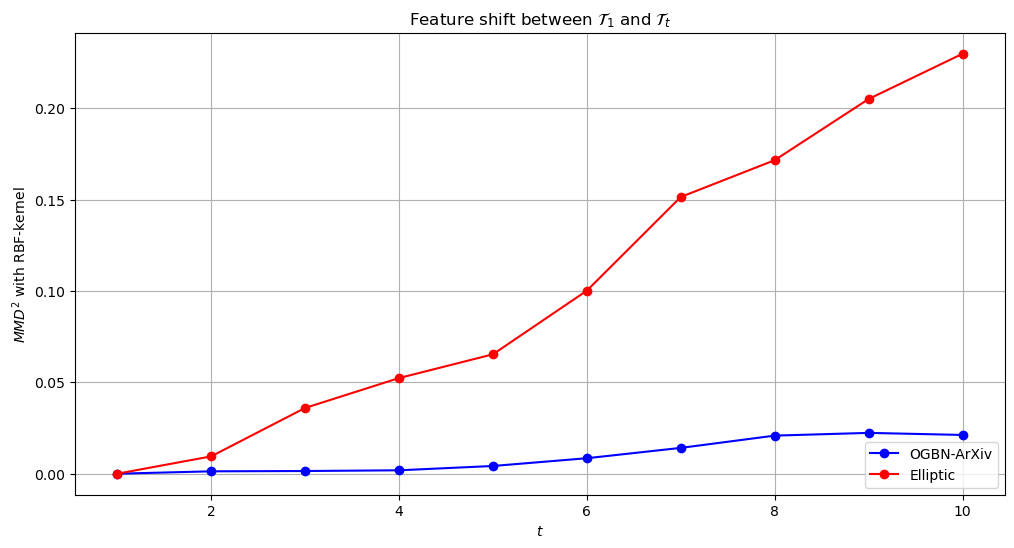

In [25]:
time10 = np.arange(1, 11)
time12 = np.arange(1, 13)
plt.figure(figsize=(12, 6))

plt.plot(time10, ogbn_shift, marker='o', linestyle='-', color='b', label='OGBN-ArXiv')
plt.plot(time10, elliptic_shift, marker='o', linestyle='-', color='r', label='Elliptic')
plt.plot(time12, dblp_shift, marker='o', linestyle='-', color='orange', label='DBLP-hard')

plt.title(r'Feature shift between $\mathcal{T}_{1}$ and $\mathcal{T}_{t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$MMD^{2}$ with RBF-kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('real_world_feature_shift.pdf', format='pdf')
plt.show()
plt.close()